In [1]:
import pandas as pd
import numpy as np
import json
import os
import sys
import matplotlib.pyplot as plt

df = pd.read_csv('../../data/tt_inscripciones_samp.csv')

In [2]:
with open('../utils.json') as f:
    dd = json.load(f)

def tweak_inscripciones(df):
    """
    
    Parameters:
    ----------
    `pd.DataFrame`: an instance of pd.DataFrame with the raw contents of the table 'inscripciones'
    """
    return (df
     .rename(columns={'usu_estado_civil': 'est_civil',
                      'usu_fecha_nac':'fec_naci',
                      'ins_sexo':'sexo',
                      'ins_fecha': 'fec_insc', # fecha de inscripcion
                      'ins_autoidentificacion': 'etnia'})       
     .assign(periodo=lambda df_: df_.periodo.astype('uint8'),
             **{c:lambda df_, c=c: df_[c].astype('uint32', errors='ignore') for c in ['cod_provincia_reside', 
                                                                                      'cod_canton_reside', 
                                                                                      'cod_parroquia_reside']},
             sexo=lambda df_: df_.sexo.replace({'SIN DATO': np.nan}).str.title().astype('category'),
             pais_res=lambda df_: df_.pais_res.str.title().astype('category'),
             etnia=lambda df_: df_.etnia.str.lower().replace(regex=dd['etnias']).str.title().astype('category'),
             escolar_no_escolar=lambda df_: df_.escolar_no_escolar.astype('category'),
             **{c:lambda df_, c=c: df_[c].astype('category') for c in ['est_civil', 'internet_domicilio', 
                                                                       'computadora_domicilio']},
             fec_naci=lambda df_: (df_
                                   .fec_naci
                                   .mask(df_.periodo!=20,
                                         pd.to_datetime(df_.fec_naci, 
                                                        format = '%d/%m/%Y', 
                                                        errors='coerce', 
                                                        exact = False))
                                   .mask(df_.periodo==20,
                                         pd.to_datetime(df_.fec_naci.where(df_.periodo==20, 45042).astype(float),
                                                        unit='d', 
                                                        origin='1900-01-01'))
                                   .pipe(lambda s: pd.to_datetime(s))
                                  ),
             fec_insc=lambda df_: (df_
                                   .fec_insc
                                   .mask(df_.periodo!=20,
                                         pd.to_datetime(df_
                                                        .fec_insc, 
                                                        format='%d/%m/%Y', 
                                                        errors='coerce', 
                                                        exact=False))
                                   .mask(df_.periodo==20,
                                         pd.to_datetime(df_.fec_insc.where(df_.periodo==20, 45042).astype(float), 
                                                        unit='d', 
                                                        origin='1900-01-01'))
                                   .pipe(lambda s: pd.to_datetime(s))
                                  ),
             edad=lambda df_: df_.fec_insc.dt.year - df_.fec_naci.dt.year,
             mes_insc=lambda df_: (df_.fec_insc.dt.month.astype('category')
                                   .cat.add_categories([2, 6, 9, 10])
                                   .cat.reorder_categories(list(range(1, 13)), 
                                                           ordered=True)))
    )

idf = tweak_inscripciones(df)

In [3]:
(idf
 .head()
 .T
)

,0,1,2,3,4
est_civil,S,S,S,S,S
fec_naci,1998-05-10 00:00:00,2002-04-09 00:00:00,2002-09-20 00:00:00,1985-06-12 00:00:00,2002-05-06 00:00:00
sexo,Mujer,Hombre,Mujer,Mujer,Mujer
fec_insc,2019-04-25 00:00:00,2021-01-15 00:00:00,2021-01-17 00:00:00,2019-12-07 00:00:00,2019-12-05 00:00:00
pais_res,Ecuador,Ecuador,Ecuador,Ecuador,Ecuador
cod_provincia_reside,10.0,9.0,4.0,9.0,9.0
cod_canton_reside,1006.0,922.0,401.0,901.0,919.0
cod_parroquia_reside,100650.0,92250.0,40102.0,90114.0,91953.0
etnia,Mestizo,Montuvio,Mestizo,Mulato,Montuvio
cod_final,1416621074.0,2397810938.0,2548550429.0,2362460974.0,2428020938.0


### Descriptive Analysis

#### Univariate Analysis: Numeric Types

There are numerical variables in the dataset. One concerns the age of the individual, another the month in which they first enrolled to take the exam. 

Text(0, 0.5, '')

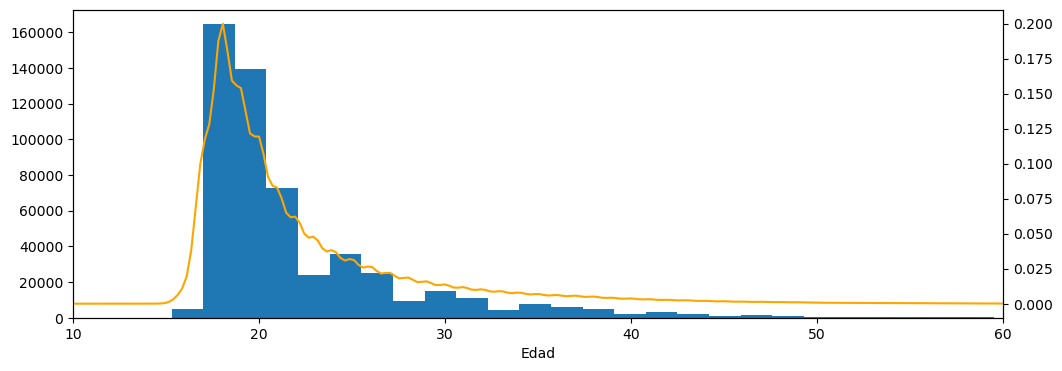

In [25]:
ax = \
(idf
 .edad
 .plot(figsize = (12, 4),
       kind='hist',
       bins=50,
       xlim=(10, 60))
)

ax_s = ax.twinx()

(idf
 .edad
 .plot(figsize = (12, 4),
       kind='kde',
       ind=700,
       color='orange',
       xlim=(10, 60),
       ylim(0, 0.22),
       ax=ax_s)
)

ax.set_xlabel('Edad')
ax.set_ylabel('')
ax_s.set_ylabel('')

In [8]:
def plot_ecdf(data):
        """Compute and plot the ECDF for a one-dimensional array of measurements.

        Parameters:
        ----------
        `data` : np.array 
        """
        n = len(data)
        x = np.sort(data)
        y = np.arange(1, n+1) / n
        
        fig, ax = plt.subplots(figsize=(12, 4))

        ax = \
        plt.plot(
            x, y,
            marker='.',
            linestyle='none'
        )

(idf
 .edad
 .pipe(lambda s: np.sort(s.unique()))
)

array([ 0.,  4.,  5.,  6.,  7.,  9., 10., 11., 12., 13., 14., 15., 16.,
       17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29.,
       30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
       56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68.,
       69., 70., 71., 72., 73., 74., 76., 77., 78., 80., 85., nan])

<Axes: >

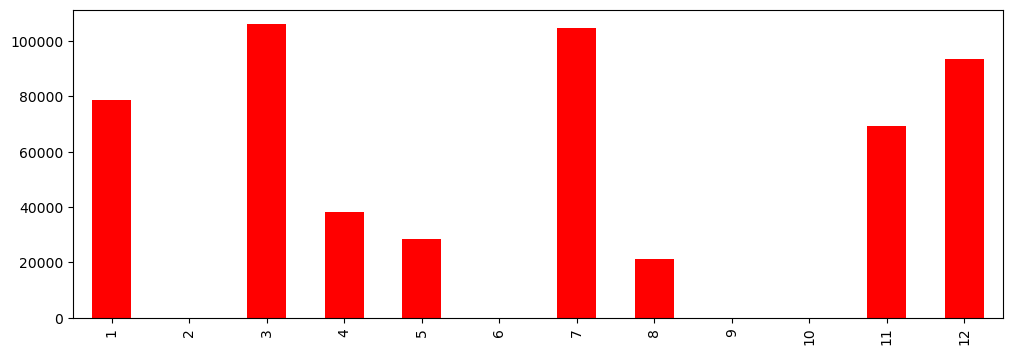

In [52]:
(idf
 .mes_insc
 .value_counts()
 .sort_index()
 .plot(figsize = (12, 4), 
       kind='bar',
       color='red',
       xticklabels=[])
)

#### Univariate Analysis: Categoricals

In [141]:
def summ_cat(df, col, index_replace=None):
    
    def rename_index(df, new):
        df.index.name = new
        return df
    
    vmax=max(df[col].value_counts())
    vmin=min(df[col].value_counts())
    
    if index_replace is None:
        index_replace = {}
    
    return (df
     .groupby(col)
     [col]
     .agg(['size'])
     .pipe(rename_index, '')
     .rename(columns={'size':'No. Total'}, 
             index=index_replace)
     .style
     .background_gradient(vmin=vmin, vmax=vmax, cmap='Oranges')
     .set_table_styles([{'selector': 'table', 'props': [('width', '500%')]}] + 
                      [{'selector': 'th.col{i}', 'props': [('width', width), ('word-wrap', 'break-word')]} 
                       for i, width in enumerate(['500px', '500px'])])
    )

In [142]:
index_replace = {'S':'Soltero', 'C':'Casado',
                 'D':'Divorciado', 'V':'Viudo',
                 'U':'Unión Libre'}

summ_cat(idf, 'est_civil', index_replace)

,No. Total
,
Casado,39861
Divorciado,5061
Soltero,492420
Unión Libre,858
Viudo,421


In [143]:
summ_cat(idf, 'sexo')

,No. Total
,
Hombre,230490
Mujer,267059


In [144]:
summ_cat(idf, 'pais_res')

,No. Total
,
Chile,1
Colombia,12
Ecuador,511480
Eslovaquia,1
España,3
Estados Unidos,3
Italia,7


In [146]:
summ_cat(idf, 'etnia')

,No. Total
,
Afroecuatoriano,16495
Blanco,11621
Indígena,24180
Mestizo,416118
Montuvio,24653
Mulato,6135
Otro,1645


In [147]:
summ_cat(idf, 'escolar_no_escolar')

,No. Total
,
Escolar,13803
No escolar,55520


In [148]:
summ_cat(idf, 'internet_domicilio')

,No. Total
,
NO,17098
SI,179784


In [149]:
summ_cat(idf, 'computadora_domicilio')

,No. Total
,
NO,35668
SI,161214


##### Spatial Distribution of individuals in the dataset 

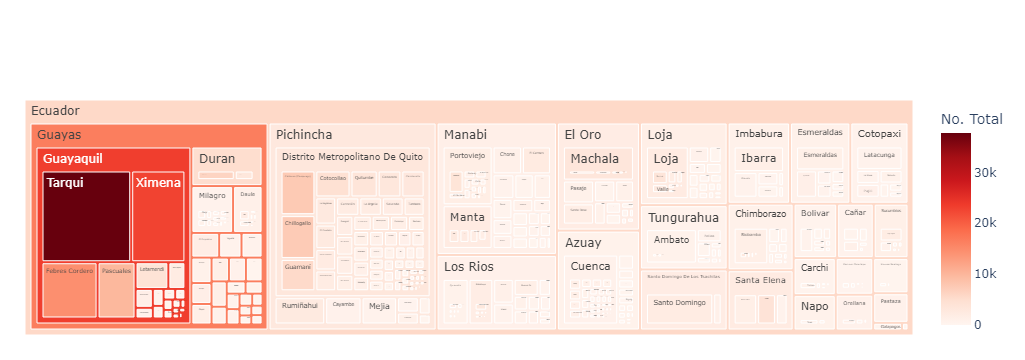

In [6]:
import plotly.express as px

gdf = pd.read_csv('../data/tt_georeference_fin.csv')

_df = \
(idf
 .groupby(['cod_canton_reside', 'cod_parroquia_reside'])
 .size()
 .reset_index()
 .rename(columns={0:'No. Total'})
 .merge(gdf, how='left', 
        left_on=['cod_canton_reside', 'cod_parroquia_reside'], 
        right_on=['cant_code', 'parr_code'])
 .dropna()
)

fig = px.treemap(
    _df,
    path=[px.Constant('Ecuador'), 'prov_name', 'cant_name', 'parr_name'],
    values='No. Total',
    hover_data=['prov_code', 'cant_code', 'parr_code', 'urbana'],
    color='No. Total',
    color_continuous_scale='Reds'
)

fig.update_layout(margin=dict(t=100, l=25, r=25, b=25))

fig